# Свёрточные сети

На семинаре мы ближе познакомимся с основным инструментом для работы с изображениями — **свёрточными сетями (convolutional neural network, CNN)**. Ниже, в качестве примера такой сети, представлена сеть [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) для распознавания рукописных знаков.

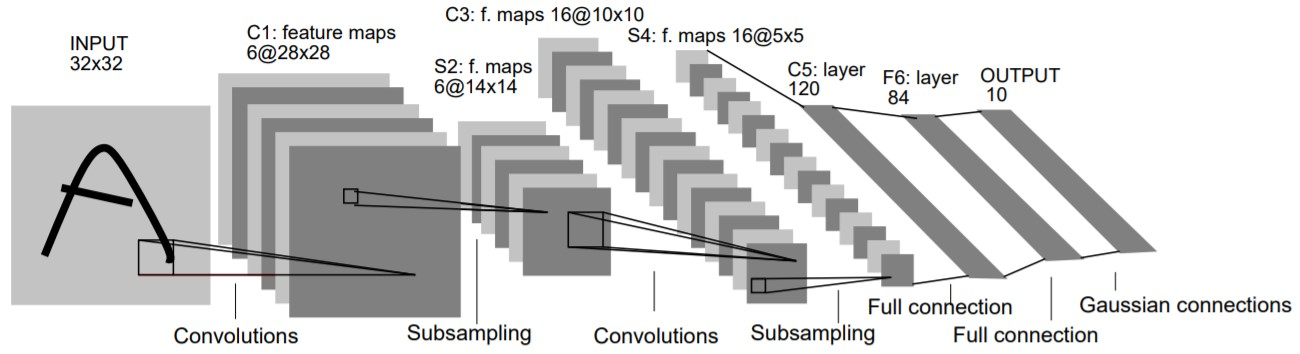

Простейшая архитектура **CNN** для классификации изображений состоит из последовательности чередующихся **свёрточных** и **пулинговых** слоёв (**pooling layer**, **subsamling**), которая завершается **полносвязными слоями (fully connected layer)**, образующими **многослойный перцептрон** (**multilayer perceptron**, **MLP**). **MLP** часто называют "головой" сети.

Функционально, свёрточная часть сети извлекает признаки из изображения, а MLP предсказывает его класс.

**План семинара:**
1. Cвёрточный слой и его параметры
- Пуллинговый слой
- Подготавливаем данные
- Простая архитектура свёрточной сети
- Обучаем сеть
- Визуализируем параметры сети
- Полезные материалы

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tqdm import tqdm_notebook

## Cвёрточный слой и его параметры

В PyTorch свёрточный слой представлен в модуле `nn` функцией [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- количество входных каналов `in_channels`
- количество выходных каналов `out_channels`
- размер ядра `kernel_size`
- шаг `stride`
- паддинг `padding`
- режим паддинга `padding_mode` (`'zeros'`, `'reflect'` и др.)
- `dilation`

In [2]:
?nn.Conv2d

**Размер ядра** `kernel_size`: `int`, если ядро квадратное, или кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свертка изображения.

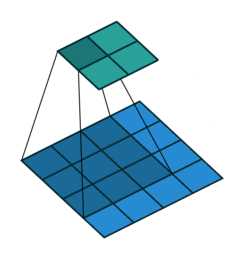

Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic)

**Шаг** `stride` — задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

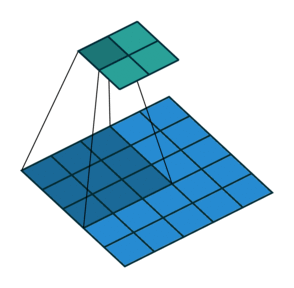

На картинке выше шаг равен 2.

**Паддинг** `padding` — количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**Half pading**
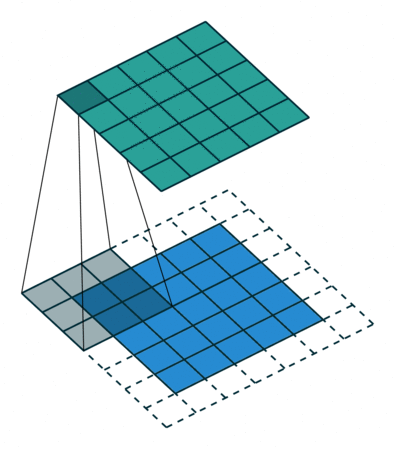

**Full padding**
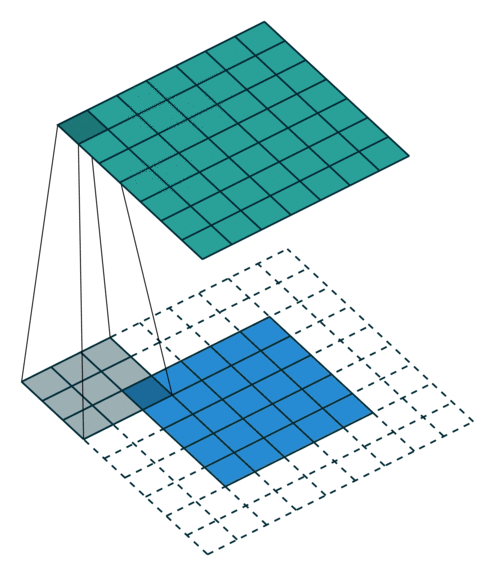

**Режим паддинга** позволяет выбрать значения пикселей, которыми дополняется изображение:
- `zeros` нулями (то есть черными пикселями)
- `reflect` отражает изображение, относительно граничных пикселей
- `replicate` копирует изображение, после чего отражает и состыковывает с изначальным

**Reflection padding**
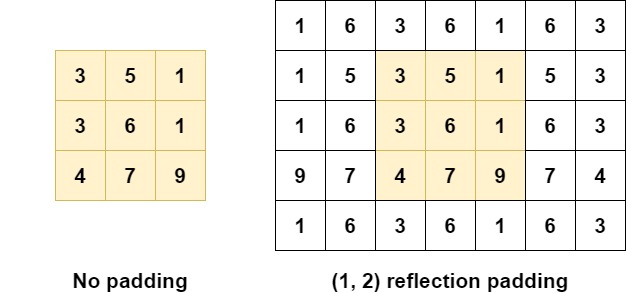

**Replication padding**
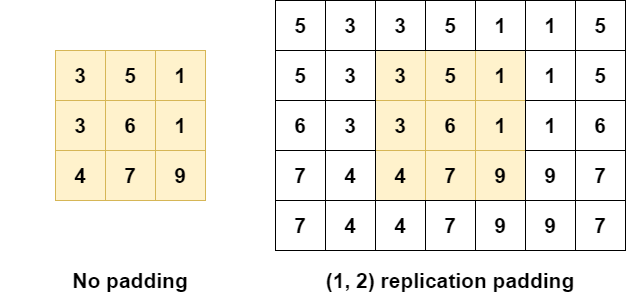

**dilation**

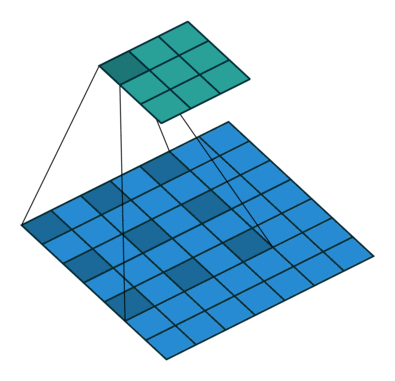

In [3]:
x = torch.randn(1, 3, 16, 16)
layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=(1, 1), padding=1, padding_mode='reflect')

In [4]:
layer(x).shape

torch.Size([1, 10, 16, 16])

## Пулинговый слой

Для пулинга в PyTorch можно использовать слои, реализованные в модуле `nn`:
- [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- [AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d)

Для них тоже можно задавать размер ядра, шаг и паддинг.

Пример использования max pooling с ядром 2х2 и шагом 2
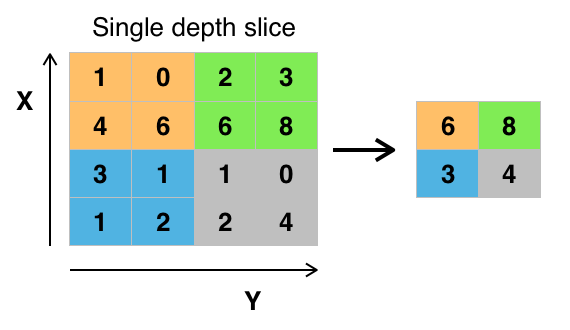

In [5]:
?nn.MaxPool2d

In [6]:
?nn.AvgPool2d

## Подготавливаем данные

Прежде чем перейти к построению архитектуры CNN давайте загрузим и подготовим данные. Будем работать с набором данных [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), в котором содержатся изображения 10 классов размером 32 на 32 пикселя с тремя каналами. В тренировочной выборке 50000 изображений, а в тестовой 10000.

Теперь опишем трансформации, которые мы хотим произвести с изображениями.
Полный список доступных преобразований можно найти [тут](https://pytorch.org/docs/stable/torchvision/transforms.html).

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), # Преобразуем изображние в тензор
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Нормализуем тензор изображения по каждому каналу

Посмотрим как работает метод `ToTensor`:

In [8]:
tr = transforms.ToTensor()

In [9]:
np.ones((3, 32, 32)) # число каналов (RGB), размер картинки — 32x32

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]])

In [10]:
tr(np.random.randint(0, 256, (3, 32, 32))) # число каналов (RGB), размер картинки — 32x32

tensor([[[102,  67, 117,  ..., 234, 112,  76],
         [253, 151, 201,  ...,  69,  81, 194],
         [ 36, 199, 248,  ..., 121,  82,  95]],

        [[178, 113, 229,  ..., 119,  32, 249],
         [227,   0,  92,  ..., 171, 100, 178],
         [ 60,  50, 149,  ..., 158, 113, 134]],

        [[209, 111, 178,  ...,  32, 153, 150],
         [ 10,  67,  93,  ...,  53, 242,  18],
         [ 26,  19, 181,  ..., 178, 240, 215]],

        ...,

        [[ 70,  92,  62,  ...,  87,  33,  75],
         [ 33, 198, 231,  ..., 223, 114,  46],
         [113,  92,  67,  ...,  88, 252,  95]],

        [[217, 248,  77,  ..., 140, 209, 187],
         [248,  81,  48,  ...,  98, 205, 133],
         [178, 108,  49,  ...,  85,  23,  61]],

        [[198, 119,  52,  ..., 169, 226,  83],
         [107,  96, 176,  ..., 149,   1, 254],
         [ 35, 245, 248,  ..., 112,  92, 190]]])

Загружаем данные и создаем `dataloader`'ы

In [11]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Давайте посмотрим на несколько тестовых изображений

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

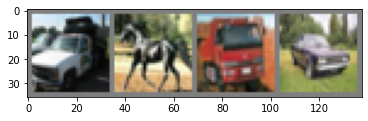

truck horse truck   car


In [13]:
def imshow(img):
    img = img / 2 + 0.5  # Убираем нормализацию
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Получаем изображения и их метки классов
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Простая архитектура свёрточной сети

Для нашей задачи подойдет простая архитектура:
1. Свёрточный слой с 6 выходными каналами и ядром 5х5
- Max pooling с ядром 2х2 и шагом 2
- Свёрточный слой с 16 выходными каналами и ядром 5х5
- Max pooling с ядром 2х2 и шагом 2
- Полносвязыный слой со 120 выходами
- Полносвязыный слой с 84 выходами
- Полносвязыный слой с 10 выходами

После каждого свёрточного и полносвзяного слоя (кроме последнего) будем использовать функцию активации ReLU.

Задайте такую сеть. Для свёрточных слоев задайте метки `conv1`, `conv2` и т.д.

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Используем свертки
        # in_channels = 3, так как у нас картинка изначально RGB
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
                                
        # Растягиваем данные из тензора в вектор
        self.flatten = nn.Flatten()
                                 
        # Используем полносвязные слои
        self.fc_1 = nn.Linear(16 * 5 * 5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Делаем сверку, потом не забываем применить нелинейность и после этого делаем пуллинг
        x = self.pool(torch.relu(self.conv_1(x)))
        x = self.pool(torch.relu(self.conv_2(x)))
        
        # Растягиваем данные из тензора в вектор
        x = self.flatten(x) # либо x.view(-1, 16 * 5 * 5)
                                 
        # Полносвязные слои
        x = torch.relu(self.fc_1(x))
        x = torch.relu(self.fc_2(x))                         
        x = self.fc_3(x)    
                                 
model = SimpleCNN()

либо можно сделать так:

In [15]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.nn = nn.Sequential(
            self.conv_1,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv_2,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)    
        )
        
    def forward(self, x):
        return self.nn(x)
                                 
model = SimpleCNN()

In [16]:
model.forward(images).shape # 4 картинки с 10 вероятностями принадлежания к каждому классу

torch.Size([4, 10])

## Обучаем сеть

В качестве функции потерь будем использовать [`CrossEntropyLoss()`](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html). Оптимизировать будем с помощью [`SGD()`](https://pytorch.org/docs/stable/optim.html?highlight=sgd#torch.optim.SGD) с параметрами `lr=0.001` и `momentum=0.9`.

In [17]:
# Задаем критерий
criterion = nn.CrossEntropyLoss()

# Инициализируем оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):
    
    running_loss = 0.0
    
    for i, data in tqdm_notebook(enumerate(trainloader, 0), total=len(trainloader)):
        images, y_test = data
        
        y_pred = model(images)
        loss = criterion(y_pred, y_test)
        
        # Считаем градиенты
        loss.backward() 
        
        # Обновляем параметры модели
        optimizer.step() 
        
        # Обнуляем градиенты, чтобы на следующем шаге опять посчитать и не аккумулировать их 
        # (если не обнулять их, то градиенты будут суммироваться)
        optimizer.zero_grad()
        
        # Печатаем статистику обучения
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print("Learning is finished.")

<ipython-input-17-9ca4a354775e>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm_notebook(enumerate(trainloader, 0), total=len(trainloader)):


[1,  2000] loss: 2.217
[1,  4000] loss: 1.880
[1,  6000] loss: 1.711
[1,  8000] loss: 1.599
[1, 10000] loss: 1.514
[1, 12000] loss: 1.497



[2,  2000] loss: 1.447
[2,  4000] loss: 1.392
[2,  6000] loss: 1.369
[2,  8000] loss: 1.372
[2, 10000] loss: 1.322
[2, 12000] loss: 1.330

Learning is finished.


Проверим какие результаты наша модель показывает на тестовых данных.

In [18]:
correct = 0
total = 0

with torch.no_grad(): # Отключает рассчет градиентов
    for data in testloader:
        images, y_test = data
        y_pred = model(images) # Получаем предсказание модели
        _, y_pred = torch.max(y_pred.data, 1) # Возвращает индекс класса с максимальным значением
        total += y_test.size(0)
        correct += (y_pred == y_test).sum().item()

print('Доля верных ответов на тестовых данных: %d %%' % (
    100 * correct / total))

Доля верных ответов на тестовых данных: 54 %


**Задание.** Поэкспериментируйте с архитектурой сети и добейтесь лучших результатов.

## Визуализируем параметры сети

In [19]:
from filter_viz import plot_filters

Давайте посмотрим, какие фильтры выучивает сеть, для этого функции `plot_filters()` надо передать свёрточный слой, фильтры которого мы визуализируем.

Параметр `single_channel` при значении `True` позволяет отображать каждый фильтр независимо, в итоге получается `in_channels` * `out_channels` фильтров. При `single_channel=False`позволяет визуализировать как RGB изображение (работает только при `in_channels=3)`.

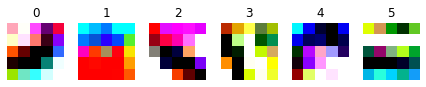

In [20]:
plot_filters(model.conv_1, single_channel=False)

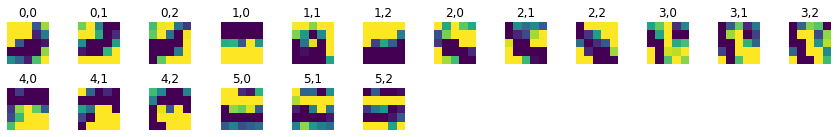

In [21]:
plot_filters(model.conv_1, single_channel=True)

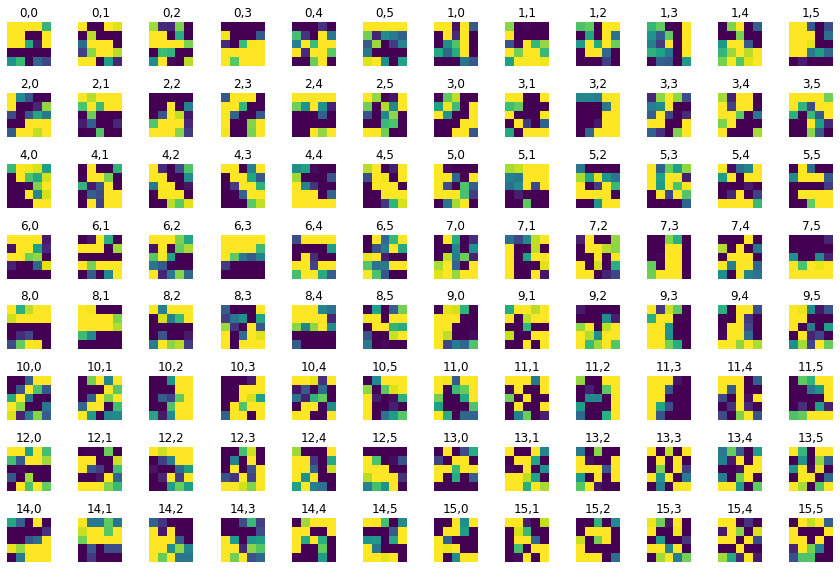

In [22]:
plot_filters(model.conv_2, single_channel=True)

## Полезные материалы

1. A guide to convolution arithmetic for deep learning [paper](https://arxiv.org/abs/1603.07285) [github](https://github.com/vdumoulin/conv_arithmetic)